In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, OneHotEncoder


In [2]:
# Load the data:
data = pd.read_csv("../data/raw/customer_segmentation/test.csv")
data.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,458989,Female,Yes,36,Yes,Engineer,0.0,Low,1.0,Cat_6,B
1,458994,Male,Yes,37,Yes,Healthcare,8.0,Average,4.0,Cat_6,A
2,458996,Female,Yes,69,No,NaN,0.0,Low,1.0,Cat_6,A
3,459000,Male,Yes,59,No,Executive,11.0,High,2.0,Cat_6,B
4,459001,Female,No,19,No,Marketing,NaN,Low,4.0,Cat_6,A


In [3]:
# Split the data:
target = "Segmentation"
features = [col for col in data if col not in [target, "ID"]]

X = data[features]
y = data[target]

# Define the data types:
num_data = ["Age", "Work_Experience", "Family_Size"] # Numerical data
cat_data = [col for col in X if col not in num_data] # Categorical data

In [4]:
# Define the pipelines:
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_data),
    ('cat', cat_transformer, cat_data)
])

# Pipeline for visualization:
vis_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=2)) # To plot 2D graph
])

# KMeans

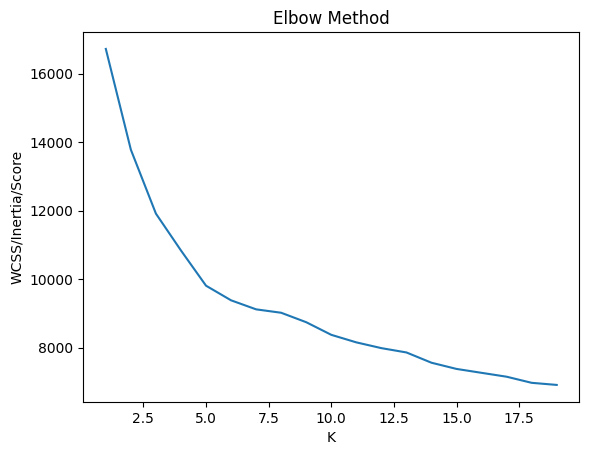

In [5]:
# Selection os better 'k' with the 'Elbow Method':
X_processed = preprocessor.fit_transform(X)
wcss = []

for k in range(1, 20):
    kmeans = KMeans(n_clusters = k, random_state=42).fit(X_processed)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 20), wcss)
plt.title("Elbow Method")
plt.xlabel("K")
plt.ylabel("WCSS/Inertia/Score")
plt.show()

In [6]:
# Defining KMeans pipeline according to the Elbow Method:
pipeline_KMeans = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=5)), 
    ('model', KMeans(n_clusters=5, init='k-means++', random_state=42)) # 5 is the best accroding to the Elbow Method
])

In [7]:
# Training the models:
cluster_labels = pipeline_KMeans.fit_predict(X)
vis_2d = vis_pipeline.fit_transform(X)

In [8]:
# DF for visualization:
vis_df = pd.DataFrame(vis_2d, columns=['PC1', 'PC2'])
vis_df['Cluster'] = cluster_labels
vis_df['Cluster'] = vis_df['Cluster'].astype(str)

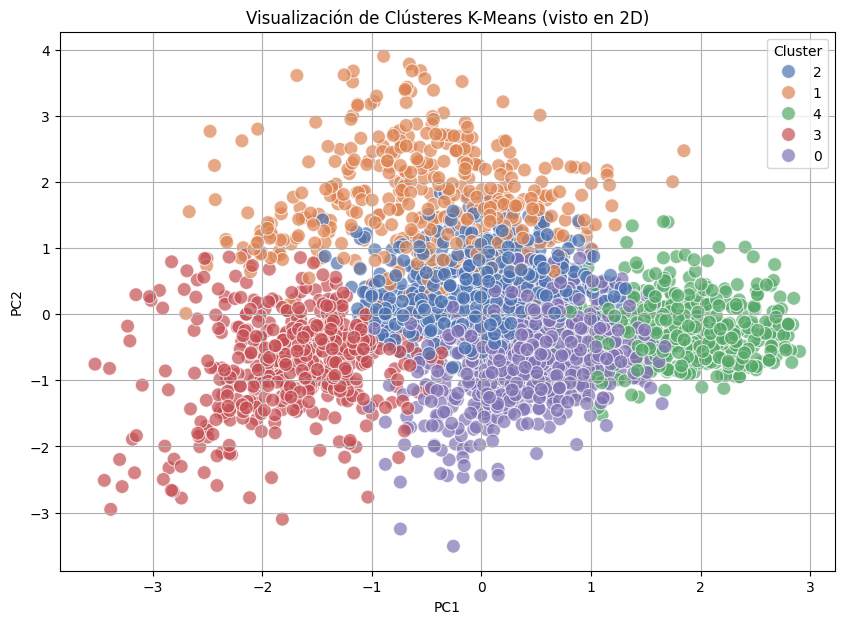

In [9]:
# Graph of clusters:
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=vis_df,
    x='PC1',
    y='PC2',
    hue='Cluster', # ¡Coloreamos por el clúster!
    palette='deep', # Colores bonitos
    s=100,
    alpha=0.7
)
plt.title('Visualización de Clústeres K-Means (visto en 2D)')
plt.grid(True)
plt.show()

# DBSCAN

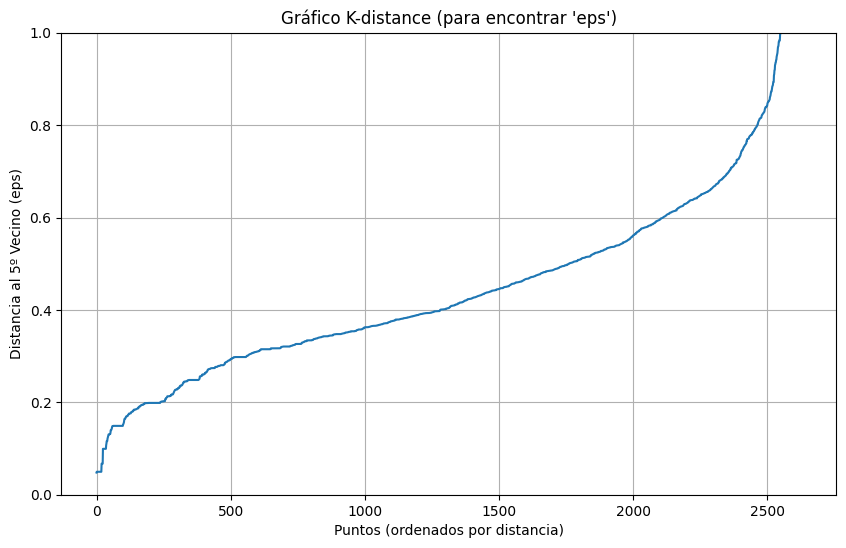

In [33]:
# Pipeline for X_processed_dbscan:
feature_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=5))
])

X_processed_dbscan = feature_pipeline.fit_transform(X)

nn = NearestNeighbors(n_neighbors=5)
nn.fit(X_processed_dbscan)

# Get distances
distances, indices = nn.kneighbors(X_processed_dbscan)

# Sort distances to the 5th neighbor
k_distances = np.sort(distances[:, 4], axis=0)

# Elbow graph
plt.figure(figsize=(10, 6))
plt.plot(k_distances)
plt.title("Gráfico K-distance (para encontrar 'eps')")
plt.xlabel("Puntos (ordenados por distancia)")
plt.ylabel("Distancia al 5º Vecino (eps)")
plt.grid(True)
plt.ylim(0, 1.0)
plt.show()

In [34]:
# Defining DBSCAN pipeline according to the Elbow Method:
pipeline_DBSCAN = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=5)), 
    ('model', DBSCAN(eps= 0.82, min_samples=5)) # ~0.82 is the best accroding to the Elbow Method
])

In [35]:
cluster_labels_dbscan = pipeline_DBSCAN.fit_predict(X)
vis_2d_dbscan = vis_pipeline.fit_transform(X)

In [36]:
# DF for visualization:
vis_df_dbscan = pd.DataFrame(vis_2d_dbscan, columns=['PC1', 'PC2'])
vis_df_dbscan['Cluster'] = cluster_labels_dbscan
vis_df_dbscan['Cluster'] = vis_df_dbscan['Cluster'].astype(str)

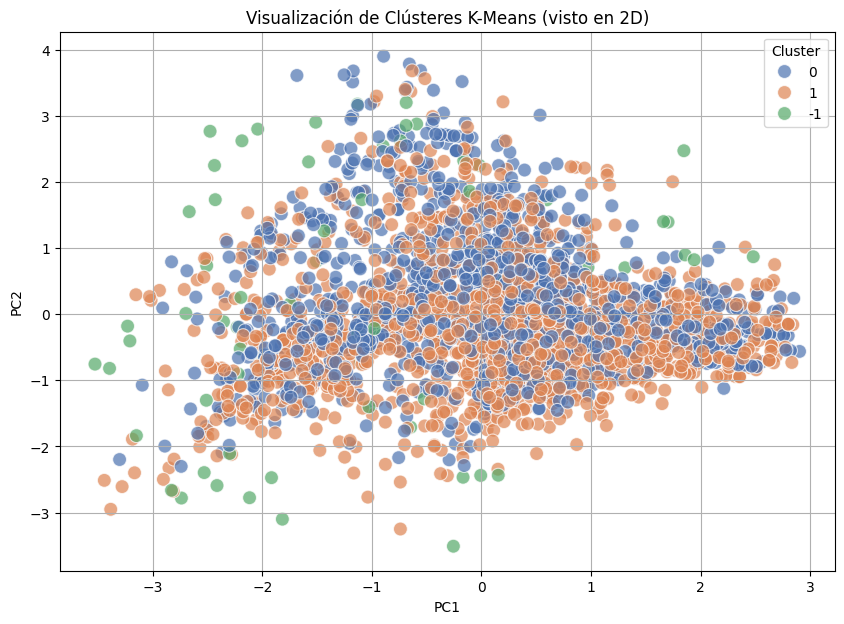

In [ ]:
# Graph of clusters:
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=vis_df_dbscan,
    x='PC1',
    y='PC2',
    hue='Cluster', # ¡Coloreamos por el clúster!
    palette='deep', # Colores bonitos
    s=100,
    alpha=0.7
)
plt.title('Visualización de Clústeres DBSCAN (visto en 2D)')
plt.grid(True)
plt.show()